In [48]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# Data

### Swissroll intuitition

In [64]:
data, sr_color = make_swiss_roll(3_000)
print(data.shape)

(3000, 3)


We get e.g 3000 points with 3 dimensions. x,y,z. Each row describes one point, the columns are the coordinate values of the corresponding dimension.

In [65]:
data[:10]

array([[ -9.46185301,  14.372351  ,  -0.45426723],
       [ -9.41818932,   1.18688251,  -2.05346092],
       [  4.36424347,  10.59866807,  -3.51685304],
       [  6.05841934,  18.90666692,   2.94292905],
       [ -6.59900856,   3.51464954,  -7.90868814],
       [ -3.30371262,  15.75096831, -10.1573451 ],
       [ -9.26923977,   5.96255981,   0.97310399],
       [ -5.70375478,   5.01360107,  -8.71562723],
       [  7.02610846,   5.83489465,  11.6374613 ],
       [  6.24349739,  15.58698498,   2.21155669]])

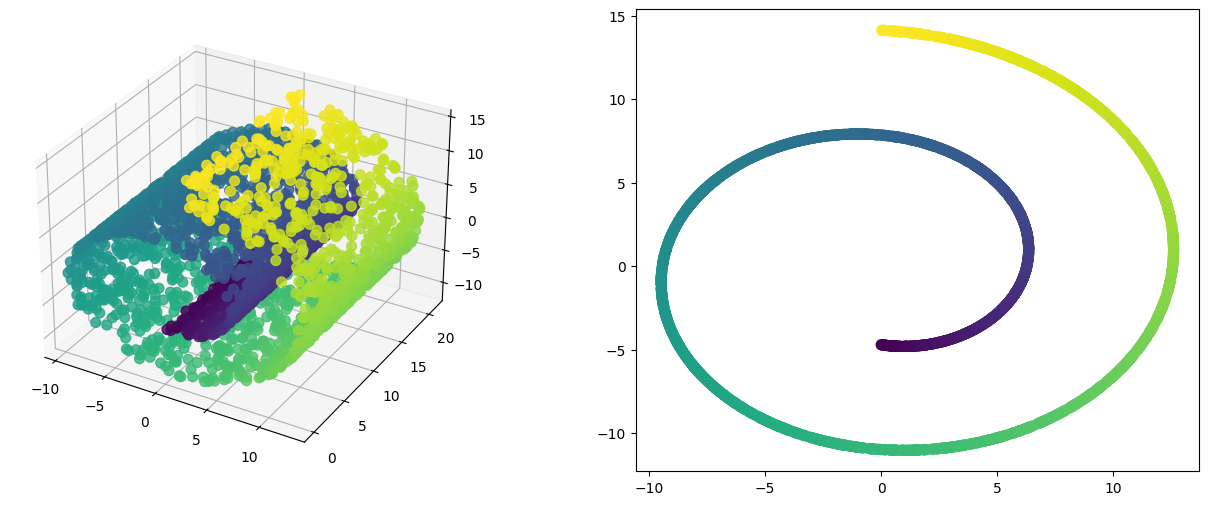

In [66]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121, projection="3d")
fig.add_axes(ax)
ax.scatter(
    data[:, 0], data[:, 1], data[:, 2], c=sr_color, s=50, alpha=0.8
)

ax = fig.add_subplot(122)
ax.scatter(
    data[:, 0], data[:, 2], c=sr_color, s=50, alpha=0.8
)

## Preprocess Data

In [67]:
# Make data similar to the paper
data = data[:, [2,0]] / 10
data = data * np.array([1, -1])

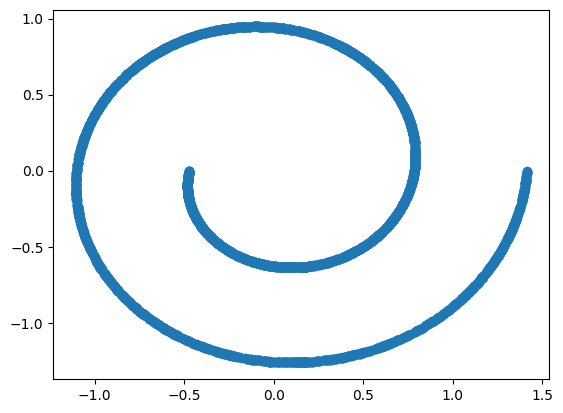

In [68]:
plt.scatter(data[:, 0], data[:, 1])

# Forward Process

In [69]:
T = 40
betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5  # Scale the data between this range

In [70]:
betas.shape

torch.Size([40])

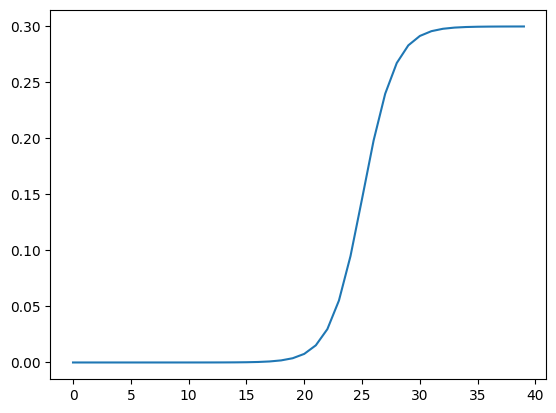

In [71]:
plt.plot(betas)

In [72]:
beta_t = betas[0]
print(beta_t)

tensor(1.0005e-05)


### Forward diffusion kernel

$$q(x^{(t)}|x^{(t-1)}) \sim N(\mu, \sigma)$$

$$q(x^{(t)}|x^{(t-1)}) \sim N(x^{(t)}; x^{(t-1)}*\sqrt{1-\beta_t}, \beta_t)$$

In [73]:
mu = torch.from_numpy(data) * torch.sqrt(1 - beta_t)
print(mu.shape)
print(mu)

torch.Size([3000, 2])
tensor([[-0.0454,  0.9462],
        [-0.2053,  0.9418],
        [-0.3517, -0.4364],
        ...,
        [-0.9734, -0.6246],
        [ 0.5327,  0.6970],
        [ 0.2037, -0.6275]], dtype=torch.float64)


In [74]:
std = torch.sqrt(beta_t)
print(std.shape)
print(std)

torch.Size([])
tensor(0.0032)


In [75]:
sampled = mu + torch.randn_like(torch.from_numpy(data)) * std

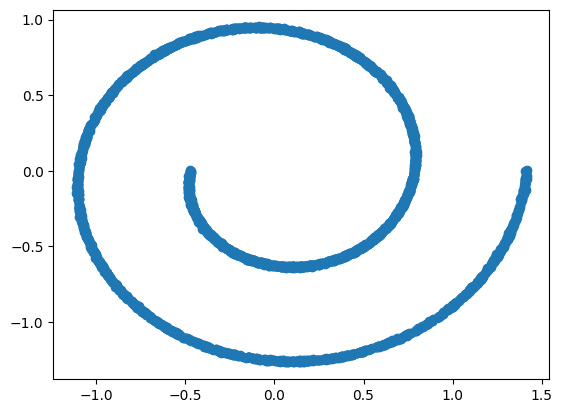

In [76]:
plt.scatter(sampled[:, 0], sampled[:, 1])

### T time steps

In [79]:
samples = []
sample = torch.from_numpy(data)

# Add noise little by little
for t in range(T):
    beta_t = betas[t]
    mu = sample * torch.sqrt(1 - beta_t)
    std = torch.sqrt(beta_t)
    
    # Reparamitrazion trick: data ~ N(mu, std)
    # Sample from random gauss (mean=0, sigma=1) and adjust it to our desired distribution
    sample = mu + torch.randn_like(sample) * std
    samples.append(sample)


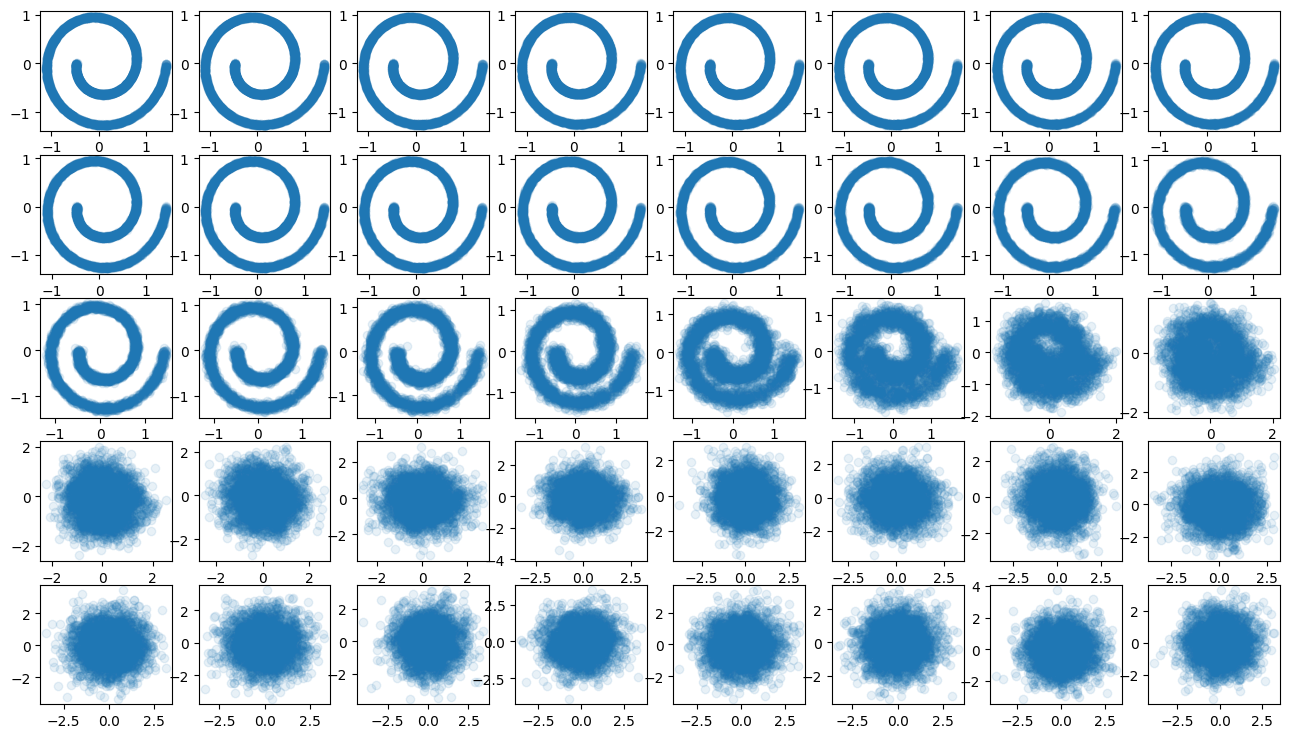

In [82]:
fig, axes = plt.subplots(5, 8, figsize=(16, 9))
for i, s in enumerate(samples):
    axes[i//8, i%8].scatter(s[:, 0], s[:, 1], alpha=0.1)

In [83]:
samples[-1].shape

torch.Size([3000, 2])

Step by step we make each point, in terms of its coordinates i.e. where it lies, a little bit noisier.